In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
model = tf.keras.applications.VGG16(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(None, None, 3))
#model.summary()

58892288/58889256 [==============================] - 0s 0us/step


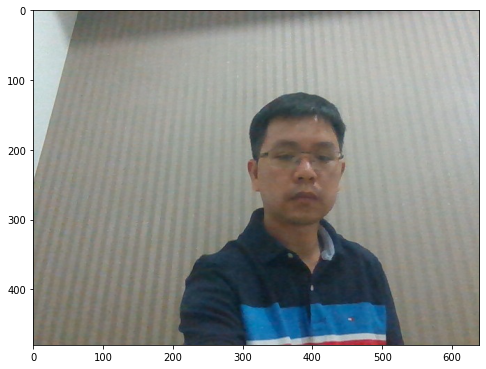

In [3]:
import matplotlib
import matplotlib.pyplot as plt

PATH = '/content/gdrive/My Drive/data/tracking_images4/'
height = 480
width  = 640
image_t1 = kimage.load_img(PATH+'img'+str(0)+'.jpg', target_size=(height, width))

plt.figure(figsize=(8,8))
plt.imshow(image_t1)

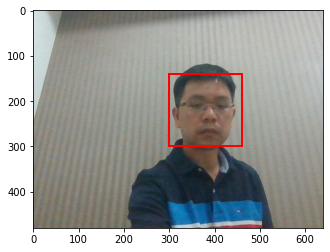

In [8]:
# given the bounding box for an object

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

fig, ax = plt.subplots()
ax.imshow(image_t1)

x = 300
y = 140
patch_side = 160

rect = patches.Rectangle((x,y), patch_side, patch_side, 
                         linewidth=2, edgecolor='r', 
                         facecolor='none')
ax.add_patch(rect)

plt.show()

(480, 640, 3)
(160, 160, 3)


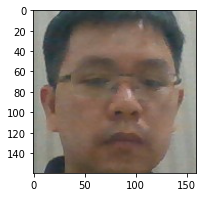

In [9]:
# get template
image_t1_np = kimage.img_to_array(image_t1)
print(image_t1_np.shape)

template_t1 = image_t1_np[y:y+patch_side, x:x+patch_side, :]
print(template_t1.shape)

plt.figure(figsize=(3,3))
plt.imshow(template_t1/255.0)

In [10]:
# compute features for template_t1
template_t1 = np.expand_dims(template_t1, axis=0)
template_t1_features = model.predict(template_t1)
print(template_t1_features.shape)

(1, 5, 5, 512)


In [12]:
def getKey(item):
    return item[0]

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# next frame
PATH = '/content/gdrive/My Drive/data/tracking_images4/'
height_fm = 15
width_fm  = 20

# Create a Rectangle patch
scale_height = height//height_fm
scale_width  = width//width_fm

# search locally
current_x = 2
current_y = 2
searching_scope = 4

for index in range(70):
  image_t2 = kimage.load_img(PATH+'img'+str(index)+'.jpg', 
                             target_size=(height, width))
  
  # compute features for image_t2
  image_t2 = np.expand_dims(image_t2, axis=0)
  image_t2_features = model.predict(image_t2)

  # matching
  side = 5
  sim_data = []  

  height_begin = max(0, current_y-searching_scope)
  height_end   = min(height_fm-side, current_y+searching_scope)

  width_begin = max(0, current_x-searching_scope)
  width_end   = min(width_fm-side, current_x+searching_scope)

  for i in range(height_begin, height_end+1):
    for j in range(width_begin, width_end+1):
      template_t2_features = image_t2_features[0,i:i+side,j:j+side,:]
      sim = cosine_similarity(np.reshape(template_t2_features, (1, -1)), 
                              np.reshape(template_t1_features, (1,-1)))
      sim_data.append((sim[0][0], i, j))

  # sort
  tp_sorted = sorted(sim_data, key=getKey, reverse=True)

  # draw bounding box
  plt.figure(figsize=(16,16))
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(image_t2[0])

  # update template
  current_x = tp_sorted[0][2]
  current_y = tp_sorted[0][1]
  template_t1 = image_t2[:,current_y*scale_height:current_y*scale_height + patch_side, current_x*scale_width:current_x*scale_width + patch_side,:]
    
  i = 0
  rect = patches.Rectangle((tp_sorted[i][2]*scale_width, tp_sorted[i][1]*scale_height), 
                          patch_side, patch_side, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.